In [1]:
%matplotlib inline

import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
#from keras.utils import to_categorical
from tensorflow.python.keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional,  GlobalMaxPooling1D, LSTM
#from tensorflow.compat.v1.keras.layers import LSTM

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

### Loading Data

In [4]:
data_path = 'D:/googledownload/random_split'
print('Available data', os.listdir(data_path))

Available data ['dev', 'test', 'train']


In [5]:
# https://www.kaggle.com/drewbryant/starter-pfam-seed-random-split

# data is randomly splitted in three folders [train(80%), test(10%), dev(10%)]
# reading and concatinating data for each folder.

def read_data(partition):
    data = []
    for fn in os.listdir(os.path.join(data_path, partition)):
        with open(os.path.join(data_path, partition, fn)) as f:
            data.append(pd.read_csv(f, index_col=None))
    return pd.concat(data)

In [6]:
# reading all data_partitions

df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')

In [15]:
df_val = df_val[(df_val['family_id']=="SRP54_N")|(df_val['family_id']== "WD40")|
       (df_val['family_id']== "OTCace_N")|(df_val['family_id']== "PEP-utilizers")|
       (df_val['family_id']== "Glycos_trans_3N")|(df_val['family_id']== "THF_DHG_CYH")|
       (df_val['family_id']== "Prenyltransf")|(df_val['family_id']== "HTH_1")|
       (df_val['family_id']== "Maf")|(df_val['family_id']== "DHH")]
df_val.to_csv('D:/googledownload/random_split/val.csv')

In [16]:
df_train = df_train[(df_train['family_id']=="SRP54_N")|(df_train['family_id']== "WD40")|
       (df_train['family_id']== "OTCace_N")|(df_train['family_id']== "PEP-utilizers")|
       (df_train['family_id']== "Glycos_trans_3N")|(df_train['family_id']== "THF_DHG_CYH")|
       (df_train['family_id']== "Prenyltransf")|(df_train['family_id']== "HTH_1")|
       (df_train['family_id']== "Maf")|(df_train['family_id']== "DHH")]
df_train.to_csv('D:/googledownload/random_split/train.csv')

In [17]:
df_test = df_test[(df_test['family_id']=="SRP54_N")|(df_test['family_id']== "WD40")|
       (df_test['family_id']== "OTCace_N")|(df_test['family_id']== "PEP-utilizers")|
       (df_test['family_id']== "Glycos_trans_3N")|(df_test['family_id']== "THF_DHG_CYH")|
       (df_test['family_id']== "Prenyltransf")|(df_test['family_id']== "HTH_1")|
       (df_test['family_id']== "Maf")|(df_test['family_id']== "DHH")]
df_test.to_csv('D:/googledownload/random_split/test.csv')

### Basic Statistics

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11213 entries, 57 to 13484
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   family_id         11213 non-null  object
 1   sequence_name     11213 non-null  object
 2   family_accession  11213 non-null  object
 3   aligned_sequence  11213 non-null  object
 4   sequence          11213 non-null  object
dtypes: object(5)
memory usage: 525.6+ KB


In [19]:
df_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
57,WD40,O48679_ARATH/318-354,PF00400.32,MSVVGA..L....R.....GH....RKA.............I...M...,MSVVGALRGHRKAIMCLAVASDLVLSGSADKSLRVWR
103,Glycos_trans_3N,A0A068Y394_ECHMU/7-69,PF02885.17,SGILSKKANG....G..SLSSTEIDYYTKEL..AE.DN...........,SGILSKKANGGSLSSTEIDYYTKELAEDNVNIAQIGAFLMAVFTRG...
172,Prenyltransf,G0WF45_NAUDC/72-290,PF01255.19,IMDGNRRYAK..SR....NLPLKK.GHEAGGI....TLLT.....L...,IMDGNRRYAKSRNLPLKKGHEAGGITLLTLVYICKKIGVKCVSAYA...
254,SRP54_N,J3VT48_9ENTR/186-249,PF02881.19,LGSGLIKLF.LG....K.K...I....DNNL.FEA....LEEQLLV...,LGSGLIKLFLGKKIDNNLFEALEEQLLVADVGIQTTRKIIDGLIAH...
460,Prenyltransf,F4AZ12_DOKS4/19-239,PF01255.19,IMDGNGRWAK..KQ....G.LLRAVGHKKGSK....AVRE.....A...,IMDGNGRWAKKQGLLRAVGHKKGSKAVREAVEAAAELGVPYLTLYA...


In [20]:
# ex: unaligned sequence
# each character reperesents one of the 24(20 common + 4 uncommon) amino acids in the sequence.

df_train.head(1)['sequence'].values[0]

'MSVVGALRGHRKAIMCLAVASDLVLSGSADKSLRVWR'

In [21]:
# Given data size
print('Train size: ', len(df_train))
print('Val size: ', len(df_val))
print('Test size: ', len(df_test))

Train size:  11213
Val size:  1397
Test size:  1397


In [22]:
def calc_unique_cls(train, test, val):
    """
    Prints # unique classes in data sets.
    """
    train_unq = np.unique(train['family_accession'].values)
    val_unq = np.unique(val['family_accession'].values)
    test_unq = np.unique(test['family_accession'].values)

    print('Number of unique classes in Train: ', len(train_unq))
    print('Number of unique classes in Val: ', len(val_unq))
    print('Number of unique classes in Test: ', len(test_unq))

In [23]:
# Unique classes in the given dataset : [df_train, df_val and df_test]

calc_unique_cls(df_train, df_test, df_val)

Number of unique classes in Train:  10
Number of unique classes in Val:  10
Number of unique classes in Test:  10


### Sequence Counts

In [24]:
# Length of sequence in train data.
df_train['seq_char_count']= df_train['sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['sequence'].apply(lambda x: len(x))
df_test['seq_char_count']= df_test['sequence'].apply(lambda x: len(x))

In [25]:
def plot_seq_count(df, data_name):
    sns.distplot(df['seq_char_count'].values)
    plt.title(f'Sequence char count: {data_name}')
    plt.grid(True)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

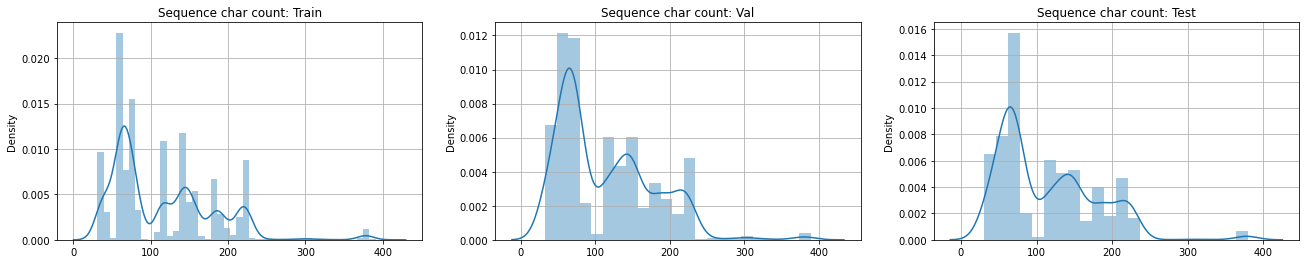

In [26]:
plt.subplot(1, 3, 1)
plot_seq_count(df_train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(df_val, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(df_test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

__Observation__
- Most of the unaligned amino acid sequences have character counts in the range of 50-250.

### Sequence Code Frequency

Amino acid sequences are represented with their corresponding 1 letter code, for example, code for alanine is (A), arginine is (R) and so on. The complete list of amino acids with there code can be found <a href='http://www.cryst.bbk.ac.uk/education/AminoAcid/the_twenty.html'>here</a>.

In [48]:
def get_code_freq(df, data_name):
  
    df = df.apply(lambda x: " ".join(x))
  
    codes = []
    for i in df: # concatination of all codes
        codes.extend(i)

    codes_dict= Counter(codes)
    codes_dict.pop(' ') # removing white space
  
    print(f'Codes: {data_name}')
    print(f'Total unique codes: {len(codes_dict.keys())}')

    df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
    return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

In [49]:
# train code sequence
train_code_freq = get_code_freq(df_train['sequence'], 'Train')
train_code_freq

Codes: Train
Total unique codes: 21


,Code,Freq
0,L,135244
1,A,119767
2,E,95894
3,V,95629
4,G,89015
5,I,88100
6,D,81500
7,S,78079
8,R,76677
9,T,72810


In [50]:
# val code sequence
val_code_freq = get_code_freq(df_val['sequence'], 'Val')
val_code_freq

Codes: Val
Total unique codes: 20


,Code,Freq
0,L,16808
1,A,14910
2,E,11793
3,V,11725
4,G,11156
5,I,10899
6,D,10179
7,S,9684
8,R,9513
9,T,8817


In [51]:
# test code sequence
test_code_freq = get_code_freq(df_test['sequence'], 'Test')
test_code_freq

Codes: Test
Total unique codes: 20


,Code,Freq
0,L,16726
1,A,14750
2,E,11884
3,V,11715
4,G,11109
5,I,10882
6,D,10152
7,S,9678
8,R,9595
9,T,8861


In [52]:
def plot_code_freq(df, data_name):
  
    plt.title(f'Code frequency: {data_name}')
    sns.barplot(x='Code', y='Freq', data=df)

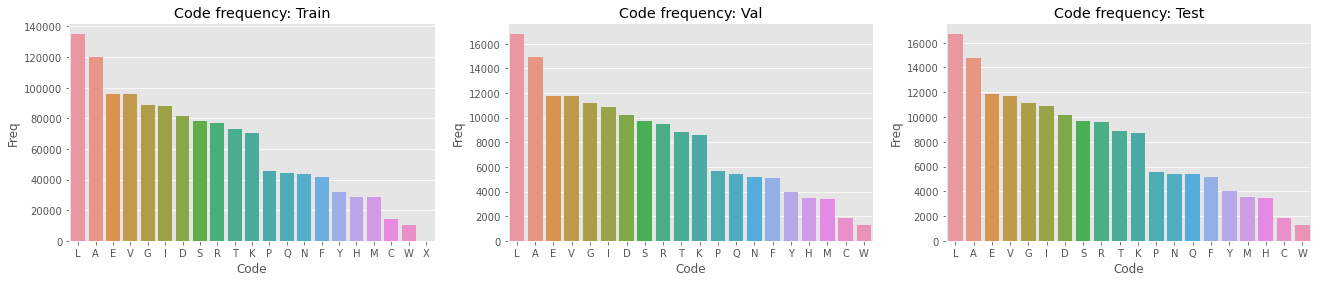

In [53]:
plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')

plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

__Observations__
- Most frequent amino acid code is L followed by A, V, G.
- As we can see, that the uncommon amino acids (i.e., X, U, B, O, Z) are present in very less quantity. Therefore we can consider only 20 common natural amino acids for sequence encoding.

### Protein families with most sequences(No. of observations)

In [28]:
df_train.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
SRP54_N            1185
WD40               1173
OTCace_N           1171
PEP-utilizers      1147
Glycos_trans_3N    1138
THF_DHG_CYH        1113
Prenyltransf       1104
HTH_1              1064
Maf                1061
DHH                1057
dtype: int64

In [29]:
df_val.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
SRP54_N            148
WD40               146
OTCace_N           146
PEP-utilizers      143
Glycos_trans_3N    142
THF_DHG_CYH        138
Prenyltransf       138
HTH_1              133
Maf                132
DHH                131
dtype: int64

In [30]:
df_test.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
SRP54_N            148
WD40               146
OTCace_N           146
PEP-utilizers      143
Glycos_trans_3N    142
THF_DHG_CYH        138
Prenyltransf       138
HTH_1              133
Maf                132
DHH                131
dtype: int64

__Observation__

- Top 20 classes are same across all the sets [train, test, val].
- Test and Val sets have almost same frequency for the top 20 classes.

### Considering 1000 classes based on no. of observations.

In [31]:
# Considering top 1000 classes based on most observations because of limited computational power.

classes = df_train['family_accession'].value_counts()[:1000].index.tolist()
len(classes)

10

In [32]:
# Filtering data based on considered 1000 classes.
train_sm = df_train.loc[df_train['family_accession'].isin(classes)].reset_index()
val_sm = df_val.loc[df_val['family_accession'].isin(classes)].reset_index()
test_sm = df_test.loc[df_test['family_accession'].isin(classes)].reset_index()

print('Data size after considering 1000 classes for each data split:')
print('Train size :', len(train_sm))
print('Val size :', len(val_sm))
print('Test size :', len(test_sm))

Data size after considering 1000 classes for each data split:
Train size : 11213
Val size : 1397
Test size : 1397


In [33]:
# No. of unique classes after reducing the data size.

calc_unique_cls(train_sm, test_sm, val_sm)

Number of unique classes in Train:  10
Number of unique classes in Val:  10
Number of unique classes in Test:  10


## 4. Deep Learning Models

### Text Preprocessing

In [34]:
# https://dmnfarrell.github.io/bioinformatics/mhclearning
# http://www.cryst.bbk.ac.uk/education/AminoAcid/the_twenty.html
# 1 letter code for 20 natural amino acids

codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
    char_dict = {}
    for index, val in enumerate(codes):
        char_dict[val] = index+1

    return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [35]:
def integer_encoding(data):
    """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
    """
  
    encode_list = []
    for row in data['sequence'].values:
        row_encode = []
        for code in row:
            row_encode.append(char_dict.get(code, 0))
        encode_list.append(np.array(row_encode))
  
    return encode_list

In [36]:
train_encode = integer_encoding(train_sm) 
val_encode = integer_encoding(val_sm) 
test_encode = integer_encoding(test_sm) 

In [37]:
# padding sequences

max_length = 100
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

train_pad.shape, val_pad.shape, test_pad.shape

((11213, 100), (1397, 100), (1397, 100))

In [38]:
# One hot encoding of sequences

train_ohe = to_categorical(train_pad)
val_ohe = to_categorical(val_pad)
test_ohe = to_categorical(test_pad)

train_ohe.shape, test_ohe.shape, test_ohe.shape 

((11213, 100, 21), (1397, 100, 21), (1397, 100, 21))

In [39]:
# del train_pad, val_pad, test_pad
# del train_encode, val_encode, test_encode

# gc.collect()

In [40]:
# label/integer encoding output variable: (y)
le = LabelEncoder()

y_train_le = le.fit_transform(train_sm['family_accession'])
y_val_le = le.transform(val_sm['family_accession'])
y_test_le = le.transform(test_sm['family_accession'])

y_train_le.shape, y_val_le.shape, y_test_le.shape

((11213,), (1397,), (1397,))

0:HTH_1  1:PEP-utilizers  2:WD40  3:THF_DHG_CYH  4:Prenyltransf  
5:DHH  6:Maf  7:OTCace_N  8:SRP54_N  9:Glycos_trans_3N

In [106]:
np.set_printoptions(threshold=np.inf)
print(y_test_le)

[2 6 1 8 0 5 9 6 8 0 0 7 9 5 8 0 2 1 5 6 5 0 6 6 4 9 5 6 6 7 9 1 2 8 5 2 1
 8 4 6 3 2 2 5 3 9 9 9 8 5 2 2 4 0 2 9 6 9 9 8 3 5 2 1 7 1 1 6 8 3 6 6 5 7
 6 4 4 0 9 2 2 3 3 6 6 6 0 2 3 7 1 3 6 5 1 6 1 3 2 7 3 4 3 9 2 6 1 7 8 5 6
 5 8 7 7 8 9 2 1 0 2 5 1 5 1 4 8 8 4 5 2 3 0 3 8 5 0 5 7 7 1 2 7 7 2 3 0 2
 8 6 2 5 6 8 2 9 8 6 0 4 5 6 5 1 8 8 8 1 5 4 7 8 2 8 6 1 7 5 2 7 5 9 8 1 1
 1 2 5 0 6 1 6 6 2 9 7 4 2 5 6 1 8 0 5 0 3 3 4 2 4 3 9 7 0 2 3 7 8 0 9 5 5
 4 6 2 4 6 3 2 8 9 5 4 8 4 6 9 0 8 4 8 5 1 4 1 1 2 2 7 5 6 2 1 2 5 0 0 6 4
 8 6 5 0 4 0 8 0 9 8 9 1 6 8 9 2 1 0 8 6 6 6 8 2 0 0 8 0 2 4 4 7 8 3 1 5 8
 3 0 6 3 8 2 3 0 5 1 5 9 7 3 9 5 7 7 2 9 7 2 4 5 0 1 7 8 4 4 7 5 3 7 7 0 4
 9 8 0 5 5 2 9 5 5 1 6 1 7 0 9 1 8 9 8 0 5 9 3 5 5 3 8 8 2 5 6 7 2 9 7 6 9
 3 3 0 1 8 5 1 5 0 1 8 3 6 0 2 4 3 6 4 1 1 7 9 2 1 3 0 3 1 8 6 0 2 9 9 7 2
 5 5 1 9 3 9 4 2 7 2 5 7 0 3 7 3 9 7 9 4 2 5 8 2 5 0 3 4 4 6 6 4 8 4 8 9 5
 2 1 7 3 4 3 3 0 5 0 5 3 2 7 1 7 1 3 9 2 6 6 6 3 5 0 8 2 8 8 9 7 6 8 1 7 3
 3 7 7 3 4 0 2 5 3 8 0 3 

In [41]:
print('Total classes: ', len(le.classes_))
# le.classes_

Total classes:  10


In [42]:
# One hot encoding of outputs
y_train = to_categorical(y_train_le)
y_val = to_categorical(y_val_le)
y_test = to_categorical(y_test_le)

y_train.shape, y_val.shape, y_test.shape

((11213, 10), (1397, 10), (1397, 10))

In [43]:
# Utility function: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [44]:
# Utility function: Display model score(Loss & Accuracy) across all sets.

def display_model_score(model, train, val, test, batch_size):

    train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
    print('Train loss: ', train_score[0])
    print('Train accuracy: ', train_score[1])
    print('-'*70)

    val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
    print('Val loss: ', val_score[0])
    print('Val accuracy: ', val_score[1])
    print('-'*70)

    test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
    print('Test loss: ', test_score[0])
    print('Test accuracy: ', test_score[1])

### Model 1: Bidirectional LSTM

In [57]:

x_input = Input(shape=(100,))
emb = Embedding(21, 128, input_length=max_length)(x_input)
bi_rnn = Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(emb)
x = Dropout(0.3)(bi_rnn)

# softmax classifier
x_output = Dense(10, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 128)          2688      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 102,794
Trainable params: 102,794
Non-trainable params: 0
_________________________________________________________________


In [58]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [59]:
history1 = model1.fit(
    train_pad, y_train,
    epochs=50, batch_size=256,
    validation_data=(val_pad, y_val),
    callbacks=[es]
    )

Epoch 1/50
44/44 [==============================] - 17s 279ms/step - loss: 7.1316 - accuracy: 0.2522 - val_loss: 4.3615 - val_accuracy: 0.4052
Epoch 2/50
44/44 [==============================] - 15s 331ms/step - loss: 3.9034 - accuracy: 0.3695 - val_loss: 2.5805 - val_accuracy: 0.7903
Epoch 3/50
44/44 [==============================] - 15s 342ms/step - loss: 2.4065 - accuracy: 0.7423 - val_loss: 1.9198 - val_accuracy: 0.8561
Epoch 4/50
44/44 [==============================] - 15s 348ms/step - loss: 1.8680 - accuracy: 0.8276 - val_loss: 1.6101 - val_accuracy: 0.8955
Epoch 5/50
44/44 [==============================] - 16s 360ms/step - loss: 1.5901 - accuracy: 0.8905 - val_loss: 1.4294 - val_accuracy: 0.9034
Epoch 6/50
44/44 [==============================] - 16s 360ms/step - loss: 1.4100 - accuracy: 0.9148 - val_loss: 1.2907 - val_accuracy: 0.9263
Epoch 7/50
44/44 [==============================] - 16s 373ms/step - loss: 1.2957 - accuracy: 0.9181 - val_loss: 1.1904 - val_accuracy: 0.9298

In [60]:
# saving model weights.
model1.save_weights('D:/googledownload/random_split/model/')

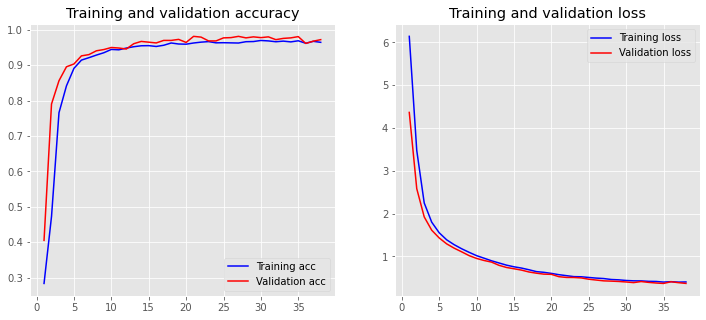

In [61]:
plot_history(history1)

In [62]:
display_model_score(model1,
    [train_pad, y_train],
    [val_pad, y_val],
    [test_pad, y_test],
    256)

44/44 [==============================] - 3s 72ms/step - loss: 0.3716 - accuracy: 0.9731
Train loss:  0.3715519309043884
Train accuracy:  0.9730669856071472
----------------------------------------------------------------------
6/6 [==============================] - 0s 67ms/step - loss: 0.3665 - accuracy: 0.9721
Val loss:  0.36648309230804443
Val accuracy:  0.9720830321311951
----------------------------------------------------------------------
6/6 [==============================] - 0s 67ms/step - loss: 0.3840 - accuracy: 0.9671
Test loss:  0.3840073049068451
Test accuracy:  0.9670723080635071


In [77]:
y_true = y_test
y_pred = model1.predict(test_pad,batch_size = 256)
for i in range(len(y_pred)):
    max_value=max(y_pred[i])
    for j in range(len(y_pred[i])):
        if max_value==y_pred[i][j]:
            y_pred[i][j]=1
        else:
            y_pred[i][j]=0

In [110]:
from sklearn import metrics
import numpy as np
#####
# Do classification task,
# then get the ground truth and the predict label named y_true and y_pred

classify_report = metrics.classification_report(y_true, y_pred)
confusion_matrix = metrics.confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
multilabel_confusion_matrix = metrics.multilabel_confusion_matrix(y_true, y_pred)
overall_accuracy = metrics.accuracy_score(y_true, y_pred)
acc_for_each_class = metrics.precision_score(y_true, y_pred, average=None)
average_accuracy = np.mean(acc_for_each_class)
score = metrics.accuracy_score(y_true, y_pred)
print('classify_report : \n', classify_report)
print('confusion_matrix : \n', confusion_matrix)
print('multilabel_confusion_matrix : \n', multilabel_confusion_matrix)
print('acc_for_each_class : \n', acc_for_each_class)
print('average_accuracy: {0:f}'.format(average_accuracy))
print('overall_accuracy: {0:f}'.format(overall_accuracy))
print('score: {0:f}'.format(score))

classify_report : 
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       133
           1       0.97      1.00      0.99       143
           2       0.99      0.99      0.99       146
           3       1.00      0.90      0.95       138
           4       0.99      0.99      0.99       138
           5       0.94      0.99      0.96       131
           6       0.94      0.99      0.96       132
           7       0.97      0.95      0.96       146
           8       0.99      0.94      0.97       148
           9       0.97      0.94      0.95       142

   micro avg       0.97      0.97      0.97      1397
   macro avg       0.97      0.97      0.97      1397
weighted avg       0.97      0.97      0.97      1397
 samples avg       0.97      0.97      0.97      1397

confusion_matrix : 
 [[130   0   2   0   0   0   0   0   0   1]
 [  0 143   0   0   0   0   0   0   0   0]
 [  1   0 145   0   0   0   0   0   0   0]
 [  0   0   0 124

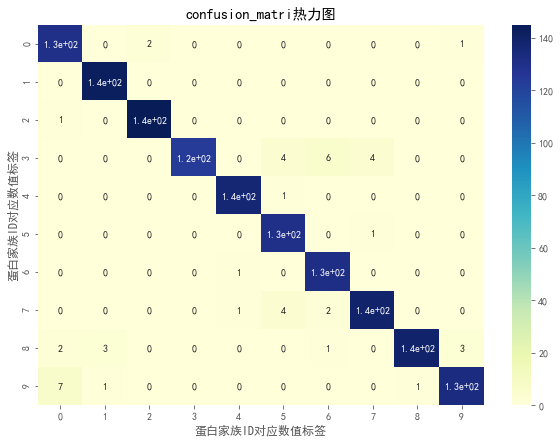

In [117]:
import seaborn as sn
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize = (10,7))
hm = sn.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")
hm.set_title('confusion_matri热力图')
hm.set_xlabel('蛋白家族ID对应数值标签')
hm.set_ylabel('蛋白家族ID对应数值标签')
plt.show()

### Model 2: ProtCNN (https://www.biorxiv.org/content/10.1101/626507v4.full)

<br/>
<center><img src='https://www.biorxiv.org/content/biorxiv/early/2019/07/15/626507/F6.large.jpg' height='470' width='700'></center>

<br/>

- One hot encoded unaligned sequence of amino acids is passed as the input to the network with zero padding.

- This network uses residual blocks inspired from [ResNet](https://arxiv.org/abs/1512.03385) architecture which also includes dilated convolutions offering larger receptive field without increasing number of model parameters.

In [63]:
def residual_block(data, filters, d_rate):
    """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
    """

    shortcut = data

    bn1 = BatchNormalization()(data)
    act1 = Activation('relu')(bn1)
    conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
    bn2 = BatchNormalization()(conv1)
    act2 = Activation('relu')(bn2)
    conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
    x = Add()([conv2, shortcut])

    return x

In [64]:
# model

x_input = Input(shape=(100, 21))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(10, activation='softmax', kernel_regularizer=l2(0.0001))(x)

model2 = Model(inputs=x_input, outputs=x_output)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 21)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 128)     2816        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 128)     512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 128)     0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [65]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [66]:
history2 = model2.fit(
    train_ohe, y_train,
    epochs=10, batch_size=256,
    validation_data=(val_ohe, y_val),
    callbacks=[es]
    )

Epoch 1/10
44/44 [==============================] - 18s 320ms/step - loss: 1.6265 - accuracy: 0.7140 - val_loss: 1.8617 - val_accuracy: 0.7824
Epoch 2/10
44/44 [==============================] - 15s 331ms/step - loss: 0.5234 - accuracy: 0.9941 - val_loss: 1.6575 - val_accuracy: 0.7767
Epoch 3/10
44/44 [==============================] - 14s 329ms/step - loss: 0.4916 - accuracy: 0.9977 - val_loss: 1.4439 - val_accuracy: 0.7573
Epoch 4/10
44/44 [==============================] - 15s 333ms/step - loss: 0.4611 - accuracy: 0.9990 - val_loss: 1.1585 - val_accuracy: 0.8683
Epoch 5/10
44/44 [==============================] - 15s 339ms/step - loss: 0.4308 - accuracy: 0.9999 - val_loss: 0.8855 - val_accuracy: 0.9499
Epoch 6/10
44/44 [==============================] - 15s 332ms/step - loss: 0.4012 - accuracy: 0.9997 - val_loss: 0.6430 - val_accuracy: 0.9921
Epoch 7/10
44/44 [==============================] - 15s 338ms/step - loss: 0.3702 - accuracy: 1.0000 - val_loss: 0.4849 - val_accuracy: 0.9964

In [68]:
# saving model weights.
model2.save_weights('D:/googledownload/random_split/model2/')

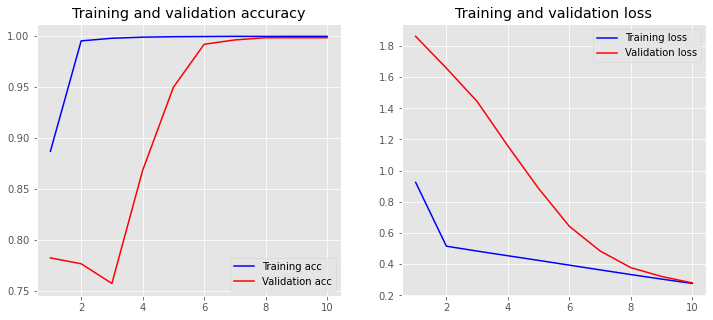

In [69]:
plot_history(history2)

In [70]:
display_model_score(
    model2,
    [train_ohe, y_train],
    [val_ohe, y_val],
    [test_ohe, y_test],
    256)

44/44 [==============================] - 3s 70ms/step - loss: 0.2742 - accuracy: 1.0000
Train loss:  0.2741888761520386
Train accuracy:  1.0
----------------------------------------------------------------------
6/6 [==============================] - 0s 63ms/step - loss: 0.2799 - accuracy: 0.9986
Val loss:  0.27990293502807617
Val accuracy:  0.9985683560371399
----------------------------------------------------------------------
6/6 [==============================] - 0s 66ms/step - loss: 0.2778 - accuracy: 1.0000
Test loss:  0.27778077125549316
Test accuracy:  1.0


In [99]:
y_true = y_test
y_pred2 = model2.predict(test_ohe,batch_size = 256)
for i in range(len(y_pred2)):
    max_value=max(y_pred2[i])
    for j in range(len(y_pred2[i])):
        if max_value==y_pred2[i][j]:
            y_pred2[i][j]=1
        else:
            y_pred2[i][j]=0

In [100]:
from sklearn import metrics
import numpy as np
#####
# Do classification task,
# then get the ground truth and the predict label named y_true and y_pred

classify_report2 = metrics.classification_report(y_true, y_pred2)
confusion_matrix2 = metrics.confusion_matrix(y_true.argmax(axis=1), y_pred2.argmax(axis=1))
multilabel_confusion_matrix2 = metrics.multilabel_confusion_matrix(y_true, y_pred2)
overall_accuracy2 = metrics.accuracy_score(y_true, y_pred2)
acc_for_each_class2 = metrics.precision_score(y_true, y_pred2, average=None)
average_accuracy2 = np.mean(acc_for_each_class2)
score2 = metrics.accuracy_score(y_true, y_pred2)
print('classify_report : \n', classify_report2)
print('confusion_matrix : \n', confusion_matrix2)
print('multilabel_confusion_matrix : \n', multilabel_confusion_matrix2)
print('acc_for_each_class : \n', acc_for_each_class2)
print('average_accuracy: {0:f}'.format(average_accuracy2))
print('overall_accuracy: {0:f}'.format(overall_accuracy2))
print('score: {0:f}'.format(score2))

classify_report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       133
           1       1.00      1.00      1.00       143
           2       1.00      1.00      1.00       146
           3       1.00      1.00      1.00       138
           4       1.00      1.00      1.00       138
           5       1.00      1.00      1.00       131
           6       1.00      1.00      1.00       132
           7       1.00      1.00      1.00       146
           8       1.00      1.00      1.00       148
           9       1.00      1.00      1.00       142

   micro avg       1.00      1.00      1.00      1397
   macro avg       1.00      1.00      1.00      1397
weighted avg       1.00      1.00      1.00      1397
 samples avg       1.00      1.00      1.00      1397

confusion_matrix : 
 [[133   0   0   0   0   0   0   0   0   0]
 [  0 143   0   0   0   0   0   0   0   0]
 [  0   0 146   0   0   0   0   0   0   0]
 [  0   0   0 138

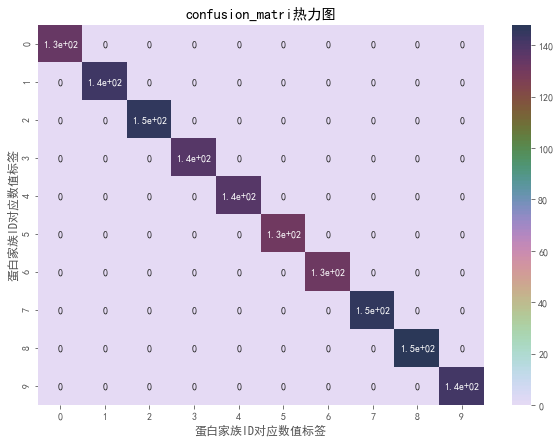

In [118]:
import seaborn as sn

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize = (10,7))
cmap = sn.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
hm = sn.heatmap(confusion_matrix2, annot=True, cmap=cmap)
hm.set_title('confusion_matri热力图')
hm.set_xlabel('蛋白家族ID对应数值标签')
hm.set_ylabel('蛋白家族ID对应数值标签')
plt.show()

## 5. Conclusion

In [71]:
x = PrettyTable()
x.field_names = ['Sr.no', 'Model', 'Train Acc', 'Val Acc','Test Acc']

x.add_row(['1.', 'Bidirectional LSTM', '0.964', '0.957', '0.958'])
x.add_row(['2.', 'ProtCNN', '0.996', '0.988', '0.988'])

print(x)

+-------+--------------------+-----------+---------+----------+
| Sr.no |       Model        | Train Acc | Val Acc | Test Acc |
+-------+--------------------+-----------+---------+----------+
|   1.  | Bidirectional LSTM |   0.964   |  0.957  |  0.958   |
|   2.  |      ProtCNN       |   0.996   |  0.988  |  0.988   |
+-------+--------------------+-----------+---------+----------+


### Reference:

- https://www.biorxiv.org/content/10.1101/626507v4.full